**Прежде всего импортируем библиотеки, которые потребуются нам в процессе работы.**

> **Let's begin with importing all the crucial libraries we'll need for work.**

In [1]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from category_encoders import CountEncoder, SumEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Укажем пути к используемым файлам данных.
> Set the paths to the data files used.

In [2]:
TRAIN_FILENAME = 'train_data_06.03-13.04.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_FILENAME = 'sample_submission.csv'

Чтобы определить качество работы модели, нам необходима метрика.
В этом соревновании используется метрика **MAPE**, которая показывает, какую долю от реальных цен составляет ошибка предсказания.

> In order to evaluate the quality of the model performance, a metric is needed.
> The metric for this competition is called **MAPE** and it shows the size of the prediction error in percentage with regard to the real price.

$$MAPE=\frac{1}{n}\sum_{t=1}^{n}\frac{\left | Y_t-\hat{Y_t} \right |}{Y_t}$$

In [8]:
def mape(y_real, y_pred):
    return np.mean(np.abs((y_pred - y_real) / y_real))

Зафиксируем некоторые параметры, которые понадобятся нам в дальнейшем.

> Set some constants for the future use.

In [9]:
RANDOM_SEED = 13
VAL_SIZE = 0.33

## Изучение и предобработка данных
> ## Data overview and preprocessing

Для начала загрузим датасеты и посмотрим, что представляют из себя данные.

> First, let's load the preprepared data and look at its main components.

In [3]:
# Подгружаем обучающий датасет и сразу удаляем дубликаты
# Load the training dataset and immediately drop possible duplicates
df_train = pd.read_csv(TRAIN_FILENAME, index_col = 0) 
df_train = df_train.drop_duplicates().reset_index(drop = True)

# Подгружаем тестовый датасет
# Load the testing dataset
df_test = pd.read_csv(TEST_FILENAME)

# Загрузим образец для submission
# Load the submission sample
sample_submission = pd.read_csv(SAMPLE_FILENAME)


# Воспользуемся парой функций, чтобы наглядно представить информацию
# Use a couple of functions to visualize the info
dataset_info = lambda df: pd.DataFrame({
    'Shape': [df.shape] + ['' for x in range(len(df.columns) - 1)], 
    'Columns': df.columns, 
    'Non-Null Count': [df[col].count() for col in df.columns]
})

pd.concat([dataset_info(df_train), 
           dataset_info(df_test)], 
          keys = ['↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓', '↓ ТЕСТОВАЯ ВЫБОРКА ↓'], 
          axis = 1, sort = False
         ).fillna('')

↓ ОБУЧАЮЩАЯ ВЫБОРКА ↓                                       \
                   Shape               Columns Non-Null Count   
0           (109080, 21)              bodyType         109079   
1                                        brand         109080   
2                                        color         109080   
3                                     fuelType         109080   
4                                    modelDate         109079   
5                                         name         109079   
6                                numberOfDoors         109079   
7                               productionDate         109080   
8                         vehicleConfiguration         109079   
9                           engineDisplacement         109079   
10                                 enginePower         109079   
11                                 description         105829   
12                                     mileage         109080   
13                                Комплектация         109080   
14                                      Привод         109079   
15                                        Руль         109080   
16                                   Владельцы         109073   
17                                         ПТС         109078   
18                                     Таможня         109080   
19                                    Владение          39889   
20                                       Price         109080   
21                                                              
22                                                              

   ↓ ТЕСТОВАЯ ВЫБОРКА ↓                                       
                  Shape               Columns Non-Null Count  
0           (35990, 23)              bodyType          35990  
1                                       brand          35990  
2                                       color          35990  
3                                    fuelType          35990  
4                                   modelDate          35990  
5                                        name          35990  
6                               numberOfDoors          35990  
7                              productionDate          35990  
8                        vehicleConfiguration          35990  
9                         vehicleTransmission          35990  
10                         engineDisplacement          35990  
11                                enginePower          35990  
12                                description          35990  
13                                    mileage          35990  
14                               Комплектация          35990  
15                                     Привод          35990  
16                                       Руль          35990  
17                                  Состояние          35990  
18                                  Владельцы          35990  
19                                        ПТС          35990  
20                                    Таможня          35990  
21                                   Владение          15370  
22                                         id          35990

Теперь посмотрим более детализированную информацию по каждому из признаков:

> Now consider a detailed information for each of the features:

In [11]:
# Вспомогательная функция
# Helper func
def features_info(df):
    return pd.DataFrame({
        'dtypes': df.dtypes.values, 
        'nunique': df.nunique().values, 
        'isna': df.isna().sum().values, 
        'unique': {x: df[x].unique() for x in df}
    }, index = df.columns)

pd.set_option('max_colwidth', 80)

pd.concat([features_info(df_train), 
           features_info(df_test)], 
          keys = ['↓ df_train ↓', '↓ df_test ↓'], 
          axis = 1, sort = False
         ).fillna('-')

↓ df_train ↓                 \
                           dtypes nunique   isna   
bodyType                   object     112      1   
brand                      object      13      0   
color                      object      16      0   
fuelType                   object       6      0   
modelDate                 float64      70      1   
name                       object    3490      1   
numberOfDoors             float64       5      1   
productionDate              int64      73      0   
vehicleConfiguration       object       4      1   
engineDisplacement         object     431      1   
enginePower               float64     330      1   
description                object   90095   3251   
mileage                     int64   23363      0   
Комплектация               object    6883      0   
Привод                     object       3      1   
Руль                       object       2      0   
Владельцы                 float64       3      7   
ПТС                        object       2      2   
Таможня                      bool       1      0   
Владение                   object     289  69191   
Price                       int64    5709      0   
vehicleTransmission             -       -      -   
Состояние                       -       -      -   
id                              -       -      -   

                                                                                                       \
                                                                                               unique   
bodyType              [Седан, Универсал 5 дв., Хэтчбек 5 дв. Sportback, Хэтчбек 3 дв., Хэтчбек 5 д...   
brand                 [AUDI, BMW, HONDA, INFINITI, LEXUS, MERCEDES, MITSUBISHI, NISSAN, SKODA, SUZ...   
color                 [040001, CACECB, 97948F, 0000CC, 4A2197, EE1D19, FAFBFB, 007F00, 22A0F8, 660...   
fuelType                                          [бензин, дизель, гибрид, электро, газ, внедорожник]   
modelDate             [1990.0, 1988.0, 1982.0, 1976.0, 1983.0, 1979.0, 1986.0, 1991.0, 1978.0, 198...   
name                  [2.3 MT (133 л.с.), 2.0 MT (115 л.с.), 2.8 AT (174 л.с.), 2.8 MT (174 л.с.) ...   
numberOfDoors                                                          [4.0, 5.0, 3.0, 2.0, 0.0, nan]   
productionDate        [1991, 1989, 1993, 1992, 1990, 1987, 1994, 1988, 1986, 1985, 1984, 1983, 198...   
vehicleConfiguration                                    [MECHANICAL, AUTOMATIC, ROBOT, VARIATOR, nan]   
engineDisplacement    [2.3, 2.0, 2.8, 2.2, 1.8, 2.0d, S4, 2.6, 2.1, 1.9, 1.6d, 1.6, 1.3, 3.3, 1.4,...   
enginePower           [133.0, 115.0, 174.0, 138.0, 90.0, 112.0, 137.0, 75.0, 136.0, 70.0, 230.0, 8...   
description           [\nБыстрым торг.Обмен интересен на авто с неисправным двигателем. \nДоброго ...   
mileage               [10000, 300000, 205636, 450000, 275250, 271800, 370000, 303000, 411000, 5717...   
Комплектация          [{'id': '0'}, {'id': '20717295', 'name': 'Ambition', 'available_options': ['...   
Привод                                                                [передний, полный, задний, nan]   
Руль                                                                                    [LEFT, RIGHT]   
Владельцы                                                                        [3.0, 2.0, 1.0, nan]   
ПТС                                                                        [ORIGINAL, DUPLICATE, nan]   
Таможня                                                                                        [True]   
Владение              [nan, {'year': 2013, 'month': 8}, {'year': 2015, 'month': 8}, {'year': 2020,...   
Price                 [135000, 42000, 200000, 119000, 125000, 185000, 130000, 145000, 110000, 1550...   
vehicleTransmission                                                                                 -   
Состояние                                                                                           -   
id                                         

Очевидно, что данные обучающей и тестовой выборки не совпадают в нескольких местах, и мы должны привести их в соответствие. 
Для этого напишем специальные функции препроцессинга отдельно для трейна и для теста.

> As we can see, our train and test datasets don't match well enough, so some adjustment is a must.
> To do this, let's write special preprocessing functions singly for each of the dataframes.

In [12]:
def train_preprocessing(train):
    BODY_TYPES = sorted(list(df_test.bodyType.unique()), reverse = True)

    COLORS_MAP = {'CACECB': 'серебристый', 'FAFBFB': 'белый', 'EE1D19': 'красный', 
                  '97948F': 'серый', '660099': 'пурпурный', '040001': 'чёрный', 
                  '4A2197': 'фиолетовый', '200204': 'коричневый', '0000CC': 'синий', 
                  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8':'голубой', 
                  'DEA522': 'золотистый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 
                  'FFC0CB':'розовый'}

    train.drop(['Таможня'], axis = 1, inplace = True)
    train.dropna(axis = 0, thresh = 18, inplace = True)

    def bodyType(row):
        for bt in BODY_TYPES:
            if row.lower().startswith(bt):
                return bt
    train['bodyType'] = train['bodyType'].apply(bodyType)
    
    train['color'] = train['color'].map(COLORS_MAP)
    train['Руль'] = train['Руль'].map({'LEFT': 'Левый', 'RIGHT': 'Правый'})
    train['ПТС'] = train['ПТС'].map({'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}).fillna('Оригинал')
    train['Владение'] = train['Владение'].fillna('nodata')

    def months_to_sent(months):
        if months == 1:
            return f'{months} месяц'
        elif 2 <= months <= 4:
            return f'{months} месяца'
        return f'{months} месяцев'
    
    def years_to_sent(years):
        if 11 <= years <= 14 or 5 <= years%10 <= 9 or years%10 == 0:
            return f'{years} лет'
        elif years%10 == 1:
            return f'{years} год'
        elif 2 <= years%10 <= 4:
            return f'{years} годa'
        
    def ownership(row):
        row = re.findall('\d+',row)
        if row != []:
            years = 2020 - (int(row[0])+1)
            months = 2 +(12 - int(row[1]))
            if years < 0:
                return months_to_sent(int(row[1]))
            elif years == 0 and months < 12:
                return months_to_sent(months)
            elif years >= 0 and months == 12:
                return years_to_sent(years + 1)
            elif years >= 0 and months > 12:
                return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
            elif years > 0 and months < 12:
                return years_to_sent(years)+' и '+months_to_sent(months)
            return None
        
    train['Владение'] = train['Владение'].apply(ownership)
    
    return train

In [13]:
def test_preprocessing(test):
    test = test.drop(['id', 'Состояние', 'Таможня', 'vehicleTransmission'], axis = 1)
    
    for feature in ['productionDate', 'mileage']:
        test[feature] = test[feature].astype('int64')
    
    test['vehicleConfiguration'] = test['vehicleConfiguration'].apply(lambda x: x.split()[1])
    test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x.split()[0])
    test['enginePower'] = test['enginePower'].apply(lambda x: float(x.split()[0]))
    test['Владельцы'] = test['Владельцы'].apply(lambda x: float(x.split()[0]))
    return test

Применим функции приведения и снова посмотрим на данные..

Let's now cast the functions and look at the data again..

In [14]:
train = train_preprocessing(df_train)
test = test_preprocessing(df_test)

pd.concat([features_info(train), 
           features_info(test)], 
          keys = ['↓ df_train ↓', '↓ df_test ↓'], 
          axis = 1, sort = False
         ).fillna('-')

↓ df_train ↓                 \
                           dtypes nunique   isna   
bodyType                   object      23      0   
brand                      object      13      0   
color                      object      16      0   
fuelType                   object       5      0   
modelDate                 float64      70      0   
name                       object    3490      0   
numberOfDoors             float64       5      0   
productionDate              int64      73      0   
vehicleConfiguration       object       4      0   
engineDisplacement         object     431      0   
enginePower               float64     330      0   
description                object   90094   3250   
mileage                     int64   23363      0   
Комплектация               object    6882      0   
Привод                     object       3      0   
Руль                       object       2      0   
Владельцы                 float64       3      6   
ПТС                        object       2      0   
Владение                   object     286  69190   
Price                       int64    5709      0   

                                                                                                       \
                                                                                               unique   
bodyType              [седан, универсал 5 дв., хэтчбек 5 дв., хэтчбек 3 дв., кабриолет, купе, лифт...   
brand                 [AUDI, BMW, HONDA, INFINITI, LEXUS, MERCEDES, MITSUBISHI, NISSAN, SKODA, SUZ...   
color                 [чёрный, серебристый, серый, синий, фиолетовый, красный, белый, зелёный, гол...   
fuelType                                                       [бензин, дизель, гибрид, электро, газ]   
modelDate             [1990.0, 1988.0, 1982.0, 1976.0, 1983.0, 1979.0, 1986.0, 1991.0, 1978.0, 198...   
name                  [2.3 MT (133 л.с.), 2.0 MT (115 л.с.), 2.8 AT (174 л.с.), 2.8 MT (174 л.с.) ...   
numberOfDoors                                                               [4.0, 5.0, 3.0, 2.0, 0.0]   
productionDate        [1991, 1989, 1993, 1992, 1990, 1987, 1994, 1988, 1986, 1985, 1984, 1983, 198...   
vehicleConfiguration                                         [MECHANICAL, AUTOMATIC, ROBOT, VARIATOR]   
engineDisplacement    [2.3, 2.0, 2.8, 2.2, 1.8, 2.0d, S4, 2.6, 2.1, 1.9, 1.6d, 1.6, 1.3, 3.3, 1.4,...   
enginePower           [133.0, 115.0, 174.0, 138.0, 90.0, 112.0, 137.0, 75.0, 136.0, 70.0, 230.0, 8...   
description           [\nБыстрым торг.Обмен интересен на авто с неисправным двигателем. \nДоброго ...   
mileage               [10000, 300000, 205636, 450000, 275250, 271800, 370000, 303000, 411000, 5717...   
Комплектация          [{'id': '0'}, {'id': '20717295', 'name': 'Ambition', 'available_options': ['...   
Привод                                                                     [передний, полный, задний]   
Руль                                                                                  [Левый, Правый]   
Владельцы                                                                        [3.0, 2.0, 1.0, nan]   
ПТС                                                                              [Оригинал, Дубликат]   
Владение              [None, 6 лет и 6 месяцев, 4 годa и 6 месяцев, 2 месяца, 11 месяцев, 5 лет и ...   
Price                 [135000, 42000, 200000, 119000, 125000, 185000, 130000, 145000, 110000, 1550...   

                     ↓ df_test ↓                 \
                          dtypes nunique   isna   
bodyType                  object      23      0   
brand                     object      13      0   
color                     object      16      0   
fuelType                  object       5      0   
modelDate                float64      51      0   
name                      object    2528      0   
numberOfDoors            float64       4      0   
productionDate             int64      49      0   
vehicleConfiguration      object       4      0   
engi

**Гораздо лучше!**

> **Much better!**

## Конструирование признаков
> ## Feature engineering

У нас уже достаточно значимых признаков, но чтобы модель работала лучше, мы можем добавить новые.
Посмотрим, что это может быть. Начнем с того, что объединим выборки для удобства обработки.

> We already have a plenty of valuable features, but in order to make the model even better we can add some more. 
> Let's see what else we can do. We'll begin with merging training and testing sets for convenience.

In [15]:
train['sample'] = 1
test['sample'] = 0
test['Price'] = 0
data = test.append(train, sort = False).reset_index(drop = True)

features_info(data)

,dtypes,nunique,isna,unique
bodyType,object,23,0,"[внедорожник 5 дв., седан, хэтчбек 5 дв., внедорожник 3 дв., лифтбек, купе-х..."
brand,object,13,0,"[MERCEDES, INFINITI, NISSAN, BMW, VOLKSWAGEN, MITSUBISHI, TOYOTA, VOLVO, SKO..."
color,object,16,0,"[синий, чёрный, белый, серый, серебристый, красный, фиолетовый, бежевый, зел..."
fuelType,object,5,0,"[бензин, дизель, гибрид, газ, электро]"
modelDate,float64,70,0,"[2015.0, 2014.0, 2009.0, 2013.0, 2007.0, 2006.0, 2012.0, 2010.0, 2003.0, 200..."
name,object,3608,0,"[250 2.0 AT (211 л.с.) 4WD, 3.7 AT (333 л.с.) 4WD, 1.6 AT (110 л.с.), M50d 3..."
numberOfDoors,float64,5,0,"[5.0, 4.0, 3.0, 2.0, 0.0]"
productionDate,int64,73,0,"[2017, 2014, 2013, 2016, 2015, 2008, 2007, 2012, 2006, 2010, 1995, 2003, 200..."
vehicleConfiguration,object,4,0,"[AUTOMATIC, ROBOT, VARIATOR, MECHANICAL]"
engineDisplacement,object,437,0,"[2.0, 3.7, 1.6, 3.0, 1.8, 3.5, 2.5, 3.8, 4.5, 4.8, 3.2, 5.5, 3.6, 2.4, 1.4, ..."


Итак, мы до сих пор не принимали во внимание признак 'description', который наверняка может содержать в себе важную и полезную для обучения модели информацию.

> So, the 'description' feature has remained untouched so far. However, it for sure may contain some significant and useful information for the model to learn.

In [16]:
data['description'] = data['description'].fillna('[]')
data['description_len'] = data['description'].apply(lambda x: len(x.split()))

Мы решили извлечь информацию о комплектующих и отделке автомобиля, которая могла бы, по нашему мнению, повлиять на его конечную стоимость.

> We decided to extract the information about car equipment and finishing, which in our opinion could affect the final price of a car.

In [17]:
# Приведем текст описания к нижнему регистру
# Bring the description text to lowercase
data['description'] = data['description'].apply(lambda x: x.lower())

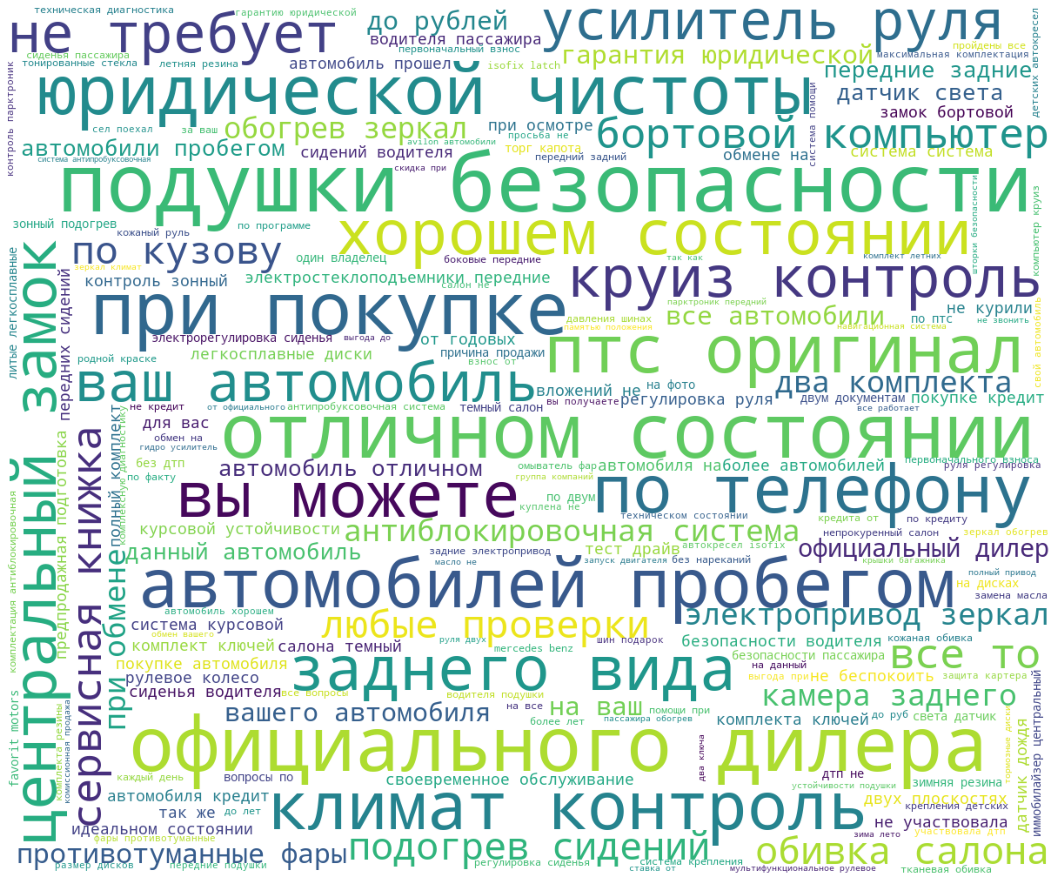

In [18]:
from wordcloud import WordCloud, STOPWORDS

full_text = ' '.join([i for i in data['description']])

cloud = WordCloud(background_color='white', width=1200, height=1000).generate_from_text(full_text)
plt.figure(figsize=(25,16))
plt.axis('off')
plt.imshow(cloud);

In [19]:
freq_phrases = list(pd.Series(WordCloud().process_text(full_text)).sort_values(ascending=False)[:100].index)

for phrase in freq_phrases:
    pattern = phrase.replace(' ', '.*?')
    data[phrase] = (data['description'].str.contains(pattern, regex=True)).astype('uint8')

Также попытаемся отыскать хотя бы самую незначительную отсылку к модели автомобиля в признаке 'name'.

> Let's also try to find at least some faint reference to a car model in the 'name' feature.

In [20]:
data['model_reference'] = data['name'].apply(lambda x: x.split()[0])

Почистим колонку 'engineDisplacement'.

> Unify the 'engineDisplacement' column.

In [21]:
def engineDisplacement(row):
    engine = re.findall('\d\.\d', str(row))
    return float(engine[0]) if engine != [] else None

data['engineDisplacement'] = data['name'].apply(engineDisplacement)
data['engineDisplacement'] = data['engineDisplacement'].fillna(0)

Заменим строковые значения для признака 'Владение' на общее количество месяцев.

> Convert 'Владение' feature string values to the total number of months.

In [22]:
def months_of_ownership(row):
    if pd.isnull(row): return
    s = row.replace('и', '').split()
    if len(s) == 2:
        return int(s[0]) * (1 if 'месяц' in s[1] else 12)
    else:
        return int(s[0]) * 12 + int(s[2])
    
data['Владение'] = data['Владение'].apply(months_of_ownership)

Заполним пропуски.

> Fill the missing values.

In [23]:
data['Владение_is_none'] = pd.isna(data['Владение']).astype('uint8')
data['Владельцы'] = data['Владельцы'].fillna(3.0)
data['Владение'] = data['Владение'].fillna(
    data.query('sample == 1')['Владение'].median())

Добавим еще пару преобразований

> Apply some more transformations

In [24]:
data['modelDate'] = 2020 - data['modelDate']
data['productionDate'] = 2020 - data['productionDate']
data['prod-model'] = data['productionDate'] - data['modelDate']

Напоследок посмотрим на распределение целевого значения.

> Before proceeding to the model assembling, let's have a last glance at our target.

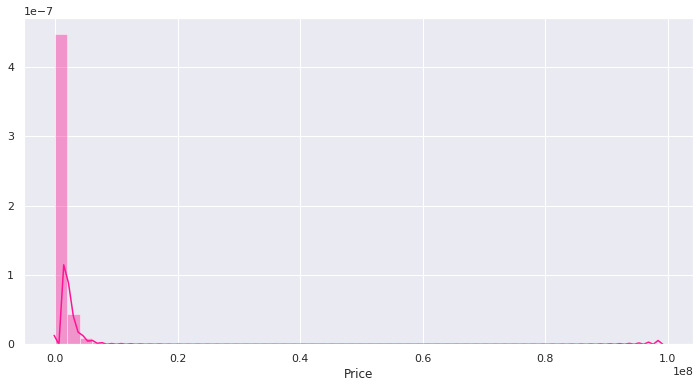

In [4]:
sns.set()
plt.figure(figsize = (12, 6))
sns.distplot(data.query('sample == 1')['Price'], color = '#FF1493');

Похоже, что распределение стоимости далеко от нормального. Исправить это можно log-нормализацией, которую мы применим позже.

> It seems that price is far from being normaly distributed. We'll fix this with the help of log normalization later.

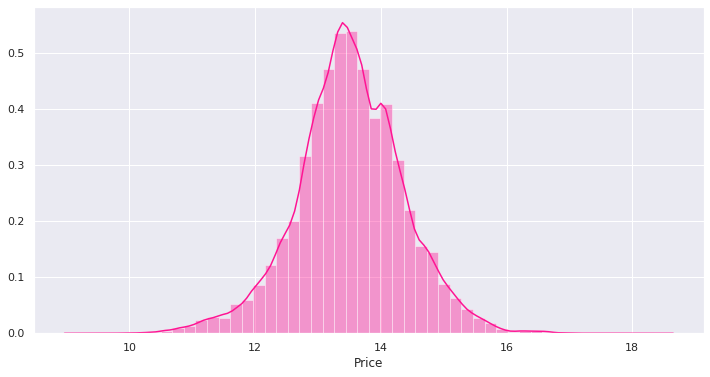

In [5]:
sns.set()
plt.figure(figsize = (12, 6))
sns.distplot(np.log(data.query('sample == 1')['Price']), color = '#FF1493');

## Обучение и тестирование модели

> ## Model training and testing

**Испробовав множество вариантов, мы в конце концов остановились на ансамбле из RandomForestRegressor и ExtraTreesRegressor и усреднении их предсказаний:**
>**After trying out many different model combinations, at last we found the one that seemed to work best, which is the ensemble of RandomForestRegressor and ExtraTreesRegressor, and averaging their predictions in the end:**

In [26]:
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleConfiguration','Привод', 'Руль', 'Владельцы', 'ПТС', 
                'engineDisplacement', 'model_reference']
encoders = ['CountEncoder','SumEncoder']

models = [RandomForestRegressor(n_estimators = 250,random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
         ExtraTreesRegressor(n_estimators = 200, random_state = RANDOM_SEED)]

scaler = StandardScaler()

predictions = pd.DataFrame()

В процессе работы моделей мы также проверяем и выкидываем самые нерабочие признаки (на основании данных из feature_importances_) и добавляем интерактивные признаки, составленные из топ-15 самых значимых
>While fitting the model we also check feature_importances_ and drop the least valuable features, and add interactive features, made of the top-15 most important of them.

In [25]:
def drop_odd_features(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    features_rate = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending=False)
    odd_features = list(features_rate[features_rate <= 0.000001].index)
    X_train.drop(odd_features, axis=1, inplace=True)
    X_test.drop(odd_features, axis=1, inplace=True)
    return X_train, X_test, features_rate

def numeric_interaction_terms(df, columns):
    for c in combinations(columns,2):
        df[f'{c[0]} / {c[1]}'] = (df[c[0]]*1.) / df[c[1]]
        df[f'{c[0]} * {c[1]}'] = df[c[0]] * df[c[1]]
        df[f'{c[0]} - {c[1]}'] = df[c[0]] - df[c[1]]
    return df

In [ ]:
for encoder, model in zip(encoders,models):
    data_transformed = eval(encoder + '(cols = cat_features, drop_invariant = True)').fit_transform(data)
    data_transformed.drop(['description', 'Комплектация', 'name'], axis = 1, inplace = True)
    train_data = data_transformed.query('sample == 1').drop('sample', axis = 1)
    test_data = data_transformed.query('sample == 0').drop(['sample', 'Price'], axis = 1)
    train_data['Price'] = np.log(train_data['Price'])
    X = train_data.drop(['Price'], axis = 1).reset_index(drop = True)
    y = train_data['Price'].values
    X_train, X_test, features_rate = drop_odd_features(X, y, test_data, model)
    inter_features = list(features_rate[:15].index)
    for column in inter_features:
        X_train[column] = scaler.fit_transform(X_train[[column]])
        X_test[column] = scaler.transform(X_test[[column]])
    X_train = numeric_interaction_terms(X_train, inter_features)
    X_test = numeric_interaction_terms(X_test, inter_features)
    X_train, X_test, features_rate = drop_odd_features(X_train, y, X_test, model)
    model.fit(X_train, y)
    predictions[models.index(model)] = np.round(np.exp(model.predict(X_test)),-3)

В конце сформируем submission
>We prepare a submission in the end

In [ ]:
now = dt.now().strftime('[%d.%m.%Y]-[%H-%M]')
sample_submission['price'] = predictions.sum(axis=1)/2
sample_submission.to_csv(f'submission_v-{now}.csv', index = False)